### Spotify Analysis

#### My Questions

1.	Does a song with several featuring artists have a better streaming performance than one with just one artist? 
> The purpose of this question is to investigate if there is a significant difference in the average number of streams for songs featuring multiple artists and those with the single featuring artist. I want to assess whether collaborations with other artists results in higher streaming numbers. This will provide insights into the potential benefits of including featuring artists to a song for its streaming success.

2.	What features of music are associated with the total number of streams on Spotify?
> The purpose of the question is to understand the factors or characteristics of music tracks that influence their popularity and streaming success on the Spotify platform. I want to identify the correlation between the features and the stream numbers. 


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from scipy.stats import levene, ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Suppress warnings from final output
import warnings
warnings.simplefilter("ignore")


In [2]:
df = pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [3]:
df.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

In [5]:
df.isna().any()

track_name              False
artist(s)_name          False
artist_count            False
released_year           False
released_month          False
released_day            False
in_spotify_playlists    False
in_spotify_charts       False
streams                 False
in_apple_playlists      False
in_apple_charts         False
in_deezer_playlists     False
in_deezer_charts        False
in_shazam_charts         True
bpm                     False
key                      True
mode                    False
danceability_%          False
valence_%               False
energy_%                False
acousticness_%          False
instrumentalness_%      False
liveness_%              False
speechiness_%           False
dtype: bool

In [6]:
df.duplicated().sum()

0

### What is the structure of your dataset?

> The spotify-2023 dataset has around 953 rows and 24 columns. The dataset have various variables in numeric and very few in object or string datatype. Each attribute provides unique insights into the characteristics of the songs and their associated metadata. 

In [7]:
df2 = df.copy()

### Does a song with several featuring artists have a better streaming performance than one with just one artist?

In [8]:
df2['artist_count'].value_counts()

1    587
2    254
3     85
4     15
5      5
6      3
8      2
7      2
Name: artist_count, dtype: int64

In [9]:
df2['streams'] = pd.to_numeric(df['streams'], errors='coerce')
df2['streams'].dtype

dtype('float64')

In [10]:
# create two dataframes for multiple artists and single artists
songs_multiple_artists = df2[df2['artist_count'] > 1]
songs_single_artist = df2[df2['artist_count'] == 1]

# Calculate the average total streams for each group
avg_streams_multiple_artists = round(songs_multiple_artists['streams'].mean())
avg_streams_single_artist = round(songs_single_artist['streams'].mean())

# Print the average streaming performance for each group
print("Average streams for songs with multiple artists:", avg_streams_multiple_artists)
print("Average streams for songs with a single artist:", avg_streams_single_artist)

Average streams for songs with multiple artists: 427559548
Average streams for songs with a single artist: 568211662


We can see that streams with a single artist are higher compaired with the streams with multiple artists but is this difference statistically significant to make the conclusion that a song with a single artist has a better streaming performance than a song with several featuring artists. To ultimately make this conclusion we need to do further test to check if the difference is statistically significant. 

To decide which test to use, we first test the variance and normality tests

Test the variance first check sample size and null values in the data

In [11]:
streams_multiple_artists = songs_multiple_artists['streams']
streams_single_artist = songs_single_artist['streams']
streams_multiple_artists.info()

<class 'pandas.core.series.Series'>
Int64Index: 366 entries, 0 to 951
Series name: streams
Non-Null Count  Dtype  
--------------  -----  
366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [12]:
streams_single_artist.info()

<class 'pandas.core.series.Series'>
Int64Index: 587 entries, 1 to 952
Series name: streams
Non-Null Count  Dtype  
--------------  -----  
586 non-null    float64
dtypes: float64(1)
memory usage: 9.2 KB


In [13]:
streams_multiple_artists.isnull().sum()

0

In [14]:
streams_single_artist.isnull().sum()

1

In [15]:
# Drop the row with null value from streams_single_artist
streams_single_artist = streams_single_artist.dropna()

# Perform Levene's test
statistic, p_value = levene(streams_multiple_artists, streams_single_artist)

# Print the results
print("Levene's test statistic:", statistic)
print("p-value:", p_value)

Levene's test statistic: 8.547723062690855
p-value: 0.003541673356671995


With a Levene's test statistic of approximately 8.55 and a p-value of approximately 0.0035, we have evidence to reject the null hypothesis of equal variances. This indicates that the variances of the streaming data for songs with multiple artists and songs with a single artist are significantly different. We then test normality


In [16]:
# Check normality of the data
 # Descriptive statistics
print('songs_multiple_artists Descriptive stats:\n ',songs_multiple_artists['streams'].describe(),'\n')
print('songs_multiple_artists Kurtosis:\n ',songs_multiple_artists['streams'].kurtosis(),'\n')
print('songs_multiple_artists Skewness:\n ',songs_multiple_artists['streams'].skew())

songs_multiple_artists Descriptive stats:
  count    3.660000e+02
mean     4.275595e+08
std      5.100355e+08
min      2.762000e+03
25%      1.155595e+08
50%      2.368647e+08
75%      5.403036e+08
max      2.808097e+09
Name: streams, dtype: float64 

songs_multiple_artists Kurtosis:
  6.138426019569954 

songs_multiple_artists Skewness:
  2.3790424461615256


In [17]:
print('songs_single_artist Descriptive stats:\n ',songs_single_artist['streams'].describe(),'\n')
print('songs_single_artist Kurtosis:\n ',songs_single_artist['streams'].kurtosis(),'\n')
print('songs_single_artist Skewness:\n ',songs_single_artist['streams'].skew())

songs_single_artist Descriptive stats:
  count    5.860000e+02
mean     5.682117e+08
std      5.936634e+08
min      1.478042e+07
25%      1.674195e+08
50%      3.336200e+08
75%      7.953355e+08
max      3.703895e+09
Name: streams, dtype: float64 

songs_single_artist Kurtosis:
  3.673988461756948 

songs_single_artist Skewness:
  1.8248341111754585


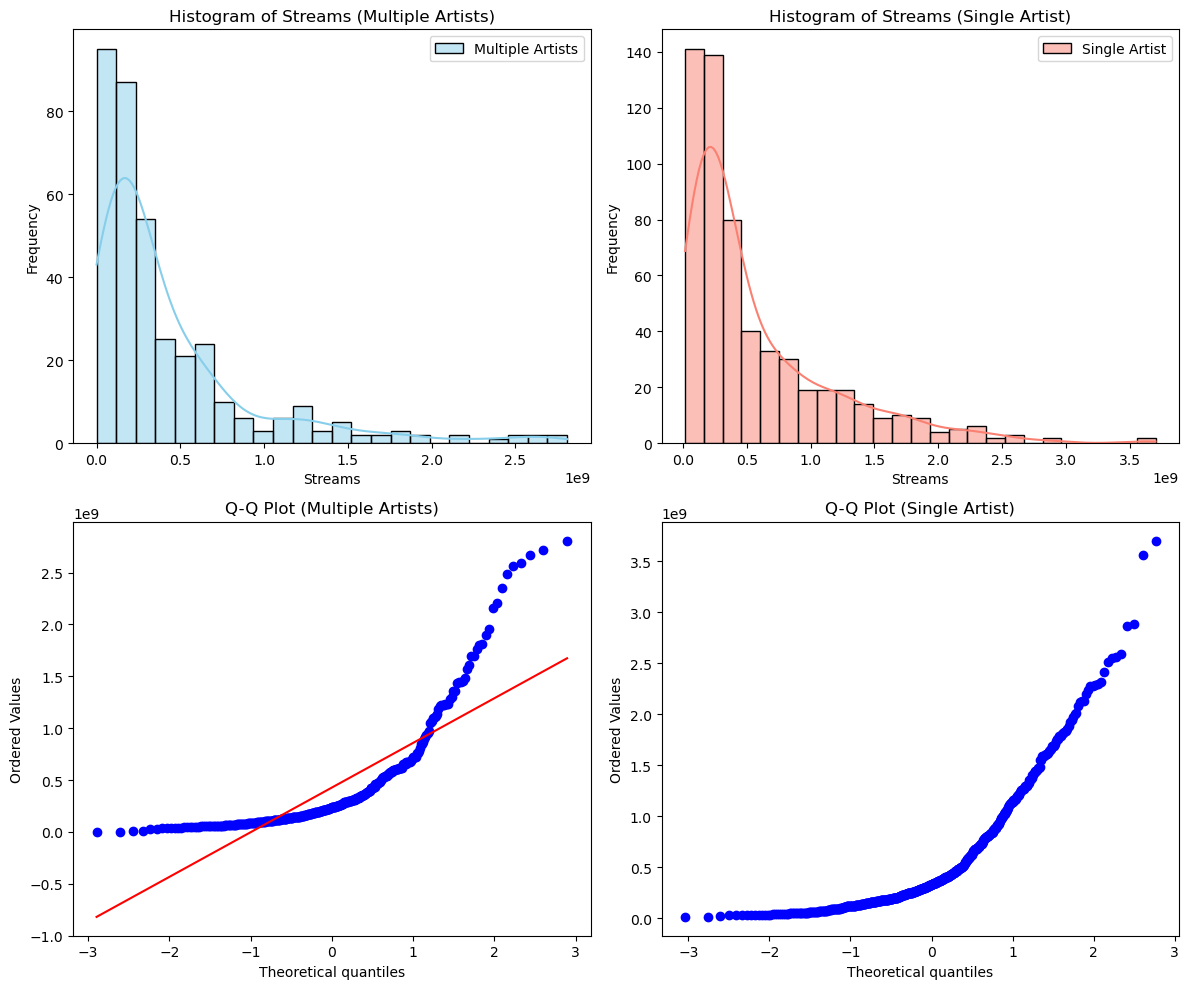

In [18]:
# Set up the figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histograms
sns.histplot(songs_multiple_artists['streams'], ax=axes[0, 0], kde=True, color='skyblue', label='Multiple Artists')
axes[0, 0].set_title('Histogram of Streams (Multiple Artists)')
axes[0, 0].set_xlabel('Streams')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

sns.histplot(songs_single_artist['streams'], ax=axes[0, 1], kde=True, color='salmon', label='Single Artist')
axes[0, 1].set_title('Histogram of Streams (Single Artist)')
axes[0, 1].set_xlabel('Streams')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Q-Q plots
stats.probplot(songs_multiple_artists['streams'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Multiple Artists)')

stats.probplot(songs_single_artist['streams'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Single Artist)')

# Adjust layout
plt.tight_layout()
plt.show()

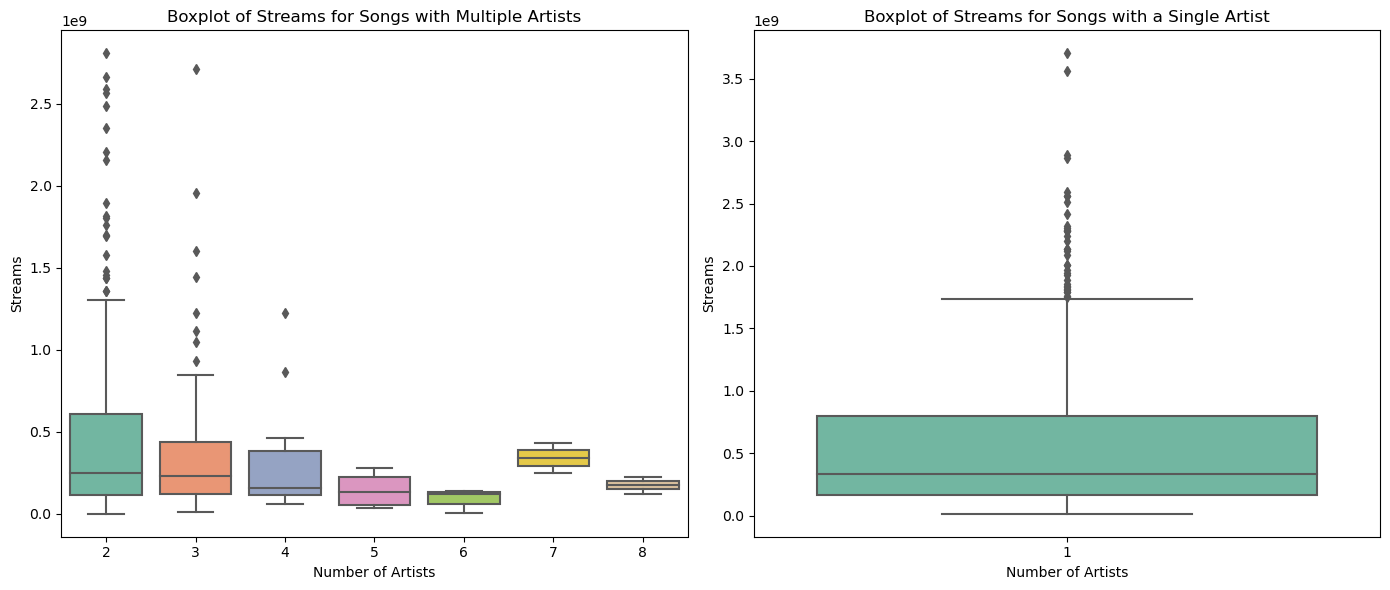

In [19]:
# Checking Outliers

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Create boxplot for songs with multiple artists
sns.boxplot(x='artist_count', y='streams', data=songs_multiple_artists, ax=axes[0], palette='Set2')
axes[0].set_title('Boxplot of Streams for Songs with Multiple Artists')
axes[0].set_xlabel('Number of Artists')
axes[0].set_ylabel('Streams')

# Create boxplot for songs with a single artist
sns.boxplot(x='artist_count', y='streams', data=songs_single_artist, ax=axes[1], palette='Set2')
axes[1].set_title('Boxplot of Streams for Songs with a Single Artist')
axes[1].set_xlabel('Number of Artists')
axes[1].set_ylabel('Streams')

# Show the plots
plt.tight_layout()
plt.show()

In [20]:
# Logarithmic transformation
songs_multiple_artists['streams_log'] = np.log1p(songs_multiple_artists['streams'])
songs_single_artist['streams_log'] = np.log1p(songs_single_artist['streams'])


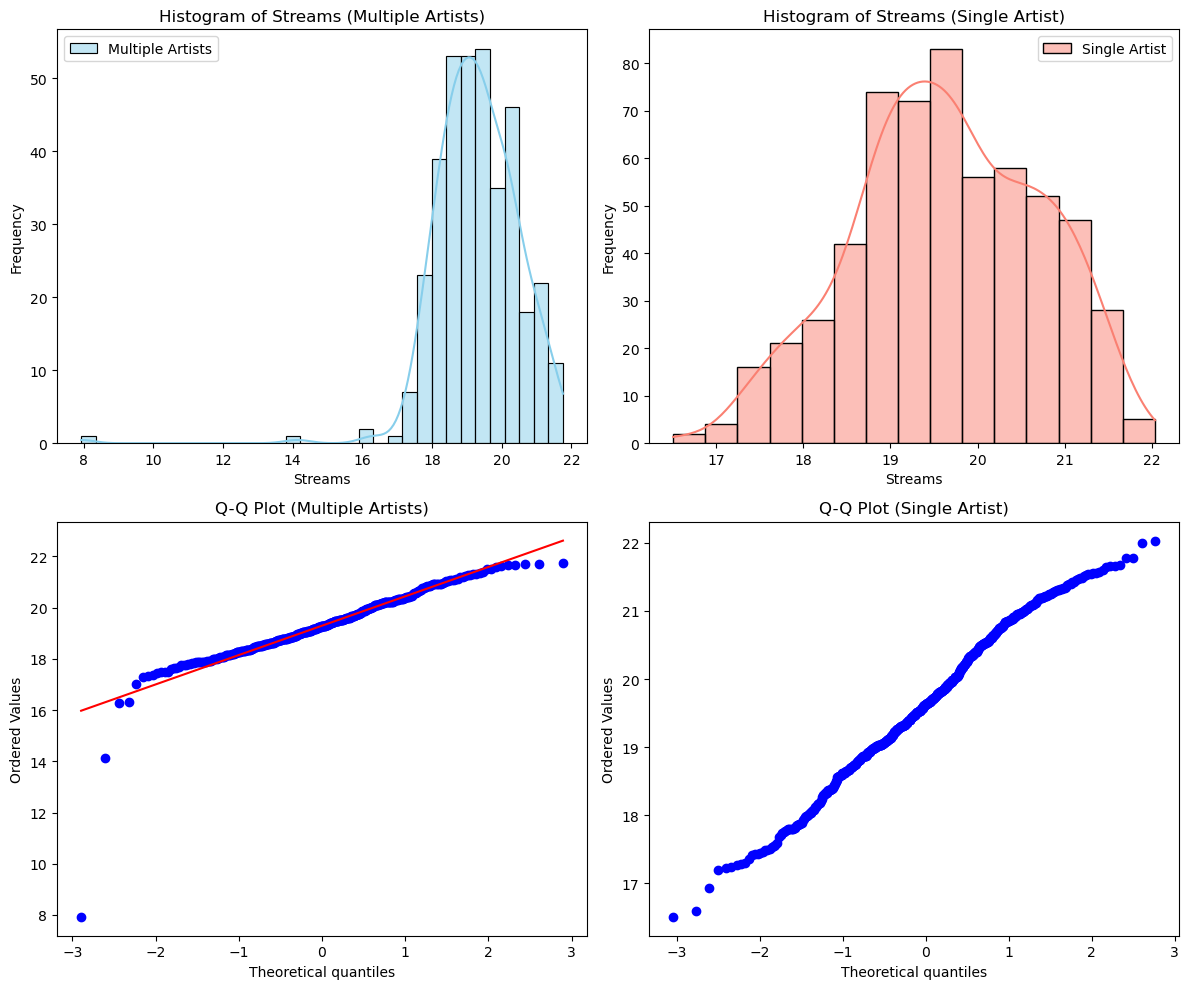

In [21]:
# Set up the figure and axes for subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histograms
sns.histplot(songs_multiple_artists['streams_log'], ax=axes[0, 0], kde=True, color='skyblue', label='Multiple Artists')
axes[0, 0].set_title('Histogram of Streams (Multiple Artists)')
axes[0, 0].set_xlabel('Streams')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

sns.histplot(songs_single_artist['streams_log'], ax=axes[0, 1], kde=True, color='salmon', label='Single Artist')
axes[0, 1].set_title('Histogram of Streams (Single Artist)')
axes[0, 1].set_xlabel('Streams')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Q-Q plots
stats.probplot(songs_multiple_artists['streams_log'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Multiple Artists)')

stats.probplot(songs_single_artist['streams_log'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Single Artist)')

# Adjust layout
plt.tight_layout()
plt.show()

In [22]:
# Normality Tests (Using Normalized stream data)

print("Shapiro-Wilk Test:")
_, p_value_multi = stats.shapiro(songs_multiple_artists['streams_log'])
_, p_value_single = stats.shapiro(songs_single_artist['streams_log'])
print("p-value for multiple artists:", p_value_multi)
print("p-value for single artist:", p_value_single)

print("\nKolmogorov-Smirnov Test:")
_, p_value_multi = stats.kstest(songs_multiple_artists['streams_log'], 'norm')
_, p_value_single = stats.kstest(songs_single_artist['streams_log'], 'norm')
print("p-value for multiple artists:", p_value_multi)
print("p-value for single artist:", p_value_single)

Shapiro-Wilk Test:
p-value for multiple artists: 5.95664471976909e-17
p-value for single artist: 1.0

Kolmogorov-Smirnov Test:
p-value for multiple artists: 0.0
p-value for single artist: nan


In [23]:
# Statistcal Normality Tests (Using Original data)

print("Shapiro-Wilk Test:")
_, p_value_multi = stats.shapiro(streams_multiple_artists)
_, p_value_single = stats.shapiro(streams_single_artist)
print("p-value for multiple artists:", p_value_multi)
print("p-value for single artist:", p_value_single)

Shapiro-Wilk Test:
p-value for multiple artists: 7.7163854324203325e-25
p-value for single artist: 8.110797426918251e-27


> For the Original data; Since the assumptions of normality and equal variances are both violated, it's recommended to use Mann-Whitney/Wilcoxon Rank Sum, 

In [25]:
# Perform Mann-Whitney U test on original data
statistic, p_value = mannwhitneyu(streams_multiple_artists, streams_single_artist)

# Print the results
print("Mann-Whitney U test statistic:", statistic)
print("p-value:", p_value)

Mann-Whitney U test statistic: 88464.0
p-value: 5.394400932557491e-06


> For Normalized data; when variances are significantly different between groups, it's recommended to use Welch's t-test, which is a modification of the independent samples t-test that doesn't assume equal variances. I perform Welch's t-test in Python using the scipy.stats.ttest_ind() function with the equal_var=False parameter:

    First, checking null values in transformed data so as to conduct Welch's t-test as it is sensitive to null data

In [26]:
songs_multiple_artists['streams_log'].isnull().sum()

0

In [27]:
songs_single_artist['streams_log'].isnull().sum()

1

In [28]:
# Find the row where the streaming data is null
null_row_index = songs_single_artist[songs_single_artist['streams_log'].isnull()].index

# Drop the row with null streaming data
songs_single_artist_cleaned = songs_single_artist.drop(index=null_row_index)
songs_single_artist_cleaned['streams_log'].isnull().sum()

0

In [29]:
# Perform Welch's t-test
t_statistic, p_value = ttest_ind(songs_multiple_artists['streams_log'], songs_single_artist_cleaned['streams_log'], equal_var=False)

# Print the results
print("Welch's t-test statistic:", t_statistic)
print("p-value:", p_value)

Welch's t-test statistic: -4.432934678740299
p-value: 1.0796533398074858e-05


> Results for Original Data:
Mann-Whitney U test statistic: 88464.0
p-value: 5.394400932557491e-06
The small p-value (less than the chosen significance level of 0.05) indicates that there is a statistically significant difference in streaming performance between the two groups. In other words, there is strong evidence to reject the null hypothesis that the mean streaming numbers are equal between the two groups. We can therefore conclude that a song with a single artist has a better streaming performance than a song with several featuring artists.  

> Results for Normalized Data:
Welch's t-test statistic: -4.4329
p-value: 1.08e-05
Interpretation: Similarly, the negative t-test statistic indicates that the mean streaming numbers for songs with multiple artists are lower than for songs with a single artist. The extremely small p-value (close to zero) indicates that this difference is highly statistically significant. Normalizing the data did not change the conclusion regarding the significance of the difference in means.

### Question 2, "What features of music are associated with the total number of streams on Spotify?"


In [30]:
 # create a new df with intrested features
    
features = df2[['streams','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%',
                'liveness_%','speechiness_%']]

In [31]:
features.head()

,streams,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,141381703.0,125,80,89,83,31,0,8,4
1,133716286.0,92,71,61,74,7,0,10,4
2,140003974.0,138,51,32,53,17,0,31,6
3,800840817.0,170,55,58,72,11,0,11,15
4,303236322.0,144,65,23,80,14,63,11,6


In [32]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
streams,952.0,5.141374e+08,5.668569e+08,2762.0,141636175.0,290530915.0,673869022.0,3.703895e+09
bpm,953.0,1.225404e+02,2.805780e+01,65.0,100.0,121.0,140.0,2.060000e+02
danceability_%,953.0,6.696957e+01,1.463061e+01,23.0,57.0,69.0,78.0,9.600000e+01
valence_%,953.0,5.143127e+01,2.348063e+01,4.0,32.0,51.0,70.0,9.700000e+01
energy_%,953.0,6.427912e+01,1.655053e+01,9.0,53.0,66.0,77.0,9.700000e+01
acousticness_%,953.0,2.705771e+01,2.599608e+01,0.0,6.0,18.0,43.0,9.700000e+01
instrumentalness_%,953.0,1.581322e+00,8.409800e+00,0.0,0.0,0.0,0.0,9.100000e+01
liveness_%,953.0,1.821301e+01,1.371122e+01,3.0,10.0,12.0,24.0,9.700000e+01
speechiness_%,953.0,1.013116e+01,9.912888e+00,2.0,4.0,6.0,11.0,6.400000e+01


In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

features['streams'] = scaler.fit_transform(features[['streams']])
features.head()

,streams,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,0.038170,125,80,89,83,31,0,8,4
1,0.036101,92,71,61,74,7,0,10,4
2,0.037798,138,51,32,53,17,0,31,6
3,0.216215,170,55,58,72,11,0,11,15
4,0.081869,144,65,23,80,14,63,11,6


In [34]:
features.isnull().sum()

streams               1
bpm                   0
danceability_%        0
valence_%             0
energy_%              0
acousticness_%        0
instrumentalness_%    0
liveness_%            0
speechiness_%         0
dtype: int64

In [35]:
features = features.dropna()

In [36]:
correlation_matrix = features.corr()
spotify_streams_correlation = correlation_matrix['streams']
print("Correlation between features and Spotify streams:")
print(spotify_streams_correlation)


Correlation between features and Spotify streams:
streams               1.000000
bpm                  -0.002438
danceability_%       -0.105457
valence_%            -0.040831
energy_%             -0.026051
acousticness_%       -0.004485
instrumentalness_%   -0.044902
liveness_%           -0.048337
speechiness_%        -0.112333
Name: streams, dtype: float64


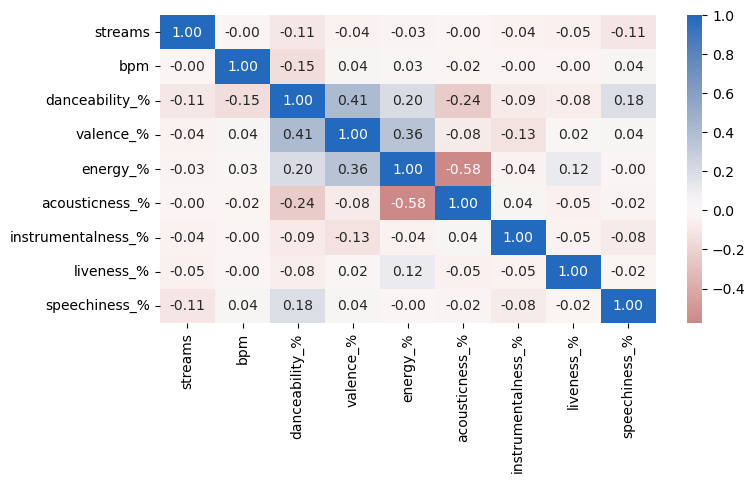

In [37]:
plt.figure(figsize = [8, 4])
sns.heatmap(features.corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)
plt.show()

Then, we perform a multiple linear regression analysis to quantify the relationship between all features and Spotify streams simultaneously. The regression results will indicate the significance and magnitude of each feature's effect on Spotify streams.

In [38]:
# Linear Regression Analysis
X = features.drop(columns=['streams'])
X = sm.add_constant(X)  # Add a constant term for the intercept
y = features['streams']

model = sm.OLS(y, X).fit()
print("\nLinear Regression Results:")
print(model.summary())


Linear Regression Results:
                            OLS Regression Results                            
Dep. Variable:                streams   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     3.558
Date:                Fri, 10 May 2024   Prob (F-statistic):           0.000450
Time:                        16:05:30   Log-Likelihood:                 450.76
No. Observations:                 952   AIC:                            -883.5
Df Residuals:                     943   BIC:                            -839.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const   